**참고**  
[tensorflow.org](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#오버샘플링)의  
[튜토리얼] > [고급] > [불균형 데이터 분류] 예시
  
이 튜토리얼에서는 한 클래스의 예시의 수가 다른 클래스보다 훨씬 많은 불균형 데이터세트를 분류하는 방법을 소개합니다.

과제 출처: [신용 카드 부정 행위 탐지](https://www.kaggle.com/mlg-ulb/creditcardfraud)
  
총 284,807건의 거래에서 492건의 부정거래만 적발하는 것이 목적입니다.

**클래스 가중치**를 정의하여 불균형 데이터로부터 모델을 학습할 수 있도록 할 것입니다.



---
터미널에서 텐서플로가 설치되어있는 가상환경을 불러와야한다.  

    conda info --envs
    conda activate {env name}
    conda deactivate

# 불균형 데이터 분류

## 설정

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 데이터 처리 및 탐색

### Kaggle 신용 카드 부정 행위 데이터 셋

In [3]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### 클래스 레이블 불균형 조사
데이터 불균형을 살펴보자

In [5]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



Positive 가 매우 적은 것을 확인할 수 있다. ---> 심각한 데이터 불균형이 있다.

### 데이터 정리, 분할 및 정규화

- **Time :** 매우 가변적이라 사용하지 못한다.    --->   삭제
- **Amount :** 로그화를 통해 범위를 줄인다.

In [6]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

#### 데이터 분할

- train : validation : test = 64% : 16% : 20% 의 비율로 분할


- train data의 label은 bool type으로 변경해준다


In [7]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels.astype('bool')
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

- 모든 특징이 연속형 변수로 알려져있다. 이것을 평균은 0, 표준편차는 1로 정규화한다.  ---> **WHY?** 성능문제 ??
    - **sklearn.preprocessing.StandardScaler(*, copy=True, with_mean=True, with_std=True) :**  

        
        
- 편차가 5를 넘어가는 자료는 **이상치(?)** 로 판단하여 처리해준다. ---> **WHY?** : 성능 문제??
    - **numpy.clip(a, a_min, a_max, out=None, **kwargs) :**   
        array 형태의 'a'에서 구간 [a_min, a_max]로 한계로 설정하여 그 값을 넘는 값을 한계값으로 제한하는 루틴
        
        
        
**참고**   
train data 기준으로 정규화를 적합하여(train data의 평균과 표준편차를 기준으로 만들게 된다.) test data 나 validation data의 peeking 을 원초적으로 제한한다.

In [8]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)
print()
print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)

Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


전처리 계산을 유하는 것이 중요하다.  레이어로 구현 하고 내보내기 전에 모델에 연결하는 것이 가장 쉬운 방법이다.

---
### 데이터 분포 살펴보기

- positive label 과 neg. label 간의 분포를 비교해보자. 유용한 질문은 다음과 같다.
    - 이러한 분포가 의미가 있나?
    - 각 분포 간의 차이가 있나?

/Users/gangtaro/opt/anaconda3/envs/tf2.3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/gangtaro/opt/anaconda3/envs/tf2.3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


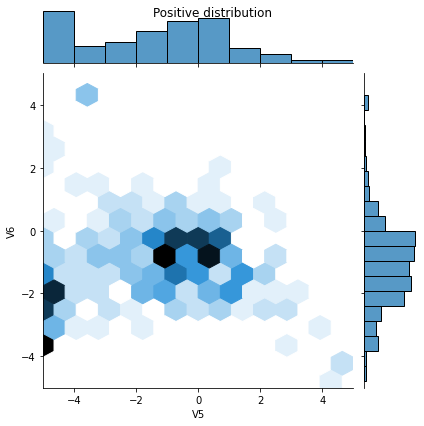

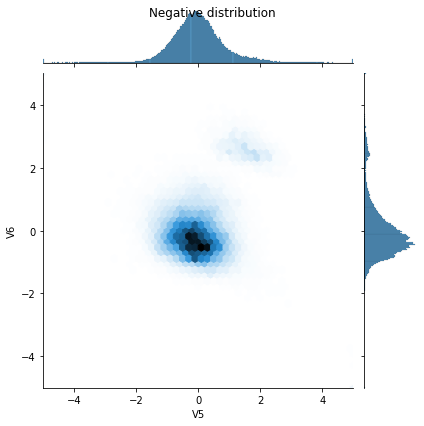

In [9]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

특징 V5와 V6의 관계만 예시로 보면 위와 같다.  


전체 데이터를 이미 정규화 했고, 그 값들은 대부분 +/- 2 사이에 밀집되어있다.


positive label을 가지는 분포에서는 negative label을 가지는 분포보다 더 극단적인 값들을 포함하는 것으로 나타난다.

---
## 모델 및 메트릭 정의

hidden layer,   
drop-out layer : 과적합을 줄이기 위해 설계,   
sigmoid layer : 출력 값 도출  

---> 신경망 생성하는 함수를 정의

In [10]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    model = keras.Sequential([

        keras.layers.Dense(
            16, activation='relu',
            input_shape=(train_features.shape[-1],)
            ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
                           bias_initializer=  output_bias  ),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

### 유용한 지표에 대한 이해

- **false** posive, **false** negative 는 **잘못**분류된 샘플
- **true** negative, **true** posivtive 는 **잘** 분류된 샘플
- **Accuracy** : 올바르게 분류된 샘플의 비율, true/all
- **Precision** : 올바르게 분류된 **예측** positive 비율, true positive/ (true +false positive)
- **Recall** : 올바르게 분류된 **실제** positive 비율, true positive/ (true positive + false negative)
- **AUC** : [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

Accuracy는 이 작업에 있어서 유용한 지표가 아니다. 항상 false를 예측해야 이작없에서 높은 정확도를 얻을 수 있다.

---
## 기준 모델
### 모델 구축

위에서 정의한  함수를 통해 모델을 만들고 학습하는 단계  
모델의 크기가 기본 배치 크기인 2048보다 큰 배치 크기를 사용해야 적합하다.  (*)  
이는 각 배치에서 몇 개의 양성 샘플을 포함할 수 있는 적절한 기회를 확보하는데 있어서 중요하다
  
참고: 이 모델은 클래스의 불균형을 잘 다루지 못합니다. 이를 이 튜토리얼의 뒷부분에서 개선하게 될 겁니다.

In [11]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [12]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


Test run the model : 

In [13]:
model.predict(train_features[:10])

array([[0.43385628],
       [0.562937  ],
       [0.33037573],
       [0.38107315],
       [0.32953227],
       [0.69105494],
       [0.6104195 ],
       [0.55094165],
       [0.75967324],
       [0.55190665]], dtype=float32)

### Option : 올바른 초기 바이어스 설정

데이터 셋이 불균형한 점에서 이런 초기추측은 좋지 않다.  이를 반영하도록 출력 계층의 바이어스를 설정->[참조](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)  

기본 바이어스 초기화를 사용하면 loss는 약 log(2) = 0.69314


In [14]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.9571


설절할 올바른 바이어스는 다음에서 파생 가능
$$
p_0 = pos/(pos+neg) = 1/(1+e^{-b_0})  \\
b_0 = -log_e(1/p_0 -1)\\
b_0 = log_e(pos/neg)
$$

In [15]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

이를 초기 바이어스로 설정하면 훨씬 더 합리적인 초기 추측을 제공.

In [16]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00020498],
       [0.00082538],
       [0.00243008],
       [0.00076583],
       [0.00076962],
       [0.00014001],
       [0.0009129 ],
       [0.00080574],
       [0.00130901],
       [0.0013985 ]], dtype=float32)

이 초기화를 통해서 초기 손실은 대략 다음과 같아야 합니다
$$
-p_0 log(p_0) - (1-p_0)log(1-p_0) = 0.01317
$$

In [17]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0120


이런 식으로 모델은 positvie 의 비율이 낮다는 것을 배우면서 처음 몇 epoch를 흘려 보낼 필요가 없어진다. 이것은 또한 훈련중 plot 의 손실을 더 쉽게 읽어 낼 수 있게 해준다.

---
### 초기 가중치 체크 포인트
다양한 훈련 실행을 더욱 비교 가능하도록 하고 싶다면 초기 모델의 가중치를 체크 포인트 파일에 보관하고 훈련 전에 각 모델에 로드 하십시오

In [18]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### 바이어스 수정이 도움이 되는지 확인

계속 진행하기 전에 조심스러운 바이어스 초기화가 실제로 도움이 되었는지 빠르게 확인하십시오

조심스럽게 초기화를 한 것과 사용하지 않은 것의 20 epoch 동안 모델을 훈련하고 손실을 비교합니다

In [19]:
# model with
# ZERO bias
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])

zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [20]:
# model with
# CAREFUL bias
model = make_model()
model.load_weights(initial_weights)

careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [22]:
def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch, history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

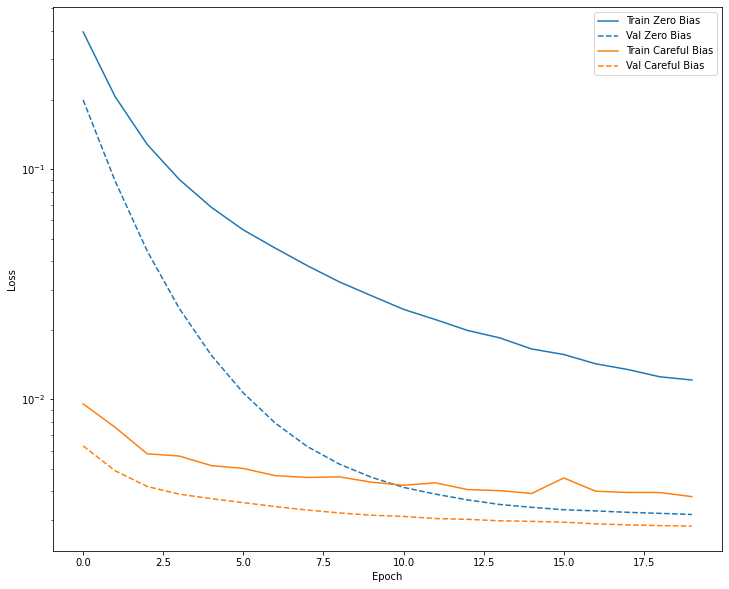

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

위의 그림은 이를 명확하게 보여줍니다. 유효성 검사 손실 측면에서 이 문제에 대해 조심스러운 초기화는 명확한 이점을 제공합니다.

### 모델 훈련



In [24]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 1s 9ms/step - loss: 0.0101 - tp: 98.0000 - fp: 10.0000 - tn: 227443.0000 - fn: 294.0000 - accuracy: 0.9987 - precision: 0.9074 - recall: 0.2500 - auc: 0.7707 - val_loss: 0.0064 - val_tp: 17.0000 - val_fp: 4.0000 - val_tn: 45486.0000 - val_fn: 62.0000 - val_accuracy: 0.9986 - val_precision: 0.8095 - val_recall: 0.2152 - val_auc: 0.8921
Epoch 2/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0071 - tp: 102.0000 - fp: 17.0000 - tn: 181946.0000 - fn: 211.0000 - accuracy: 0.9987 - precision: 0.8571 - recall: 0.3259 - auc: 0.8622 - val_loss: 0.0048 - val_tp: 41.0000 - val_fp: 6.0000 - val_tn: 45484.0000 - val_fn: 38.0000 - val_accuracy: 0.9990 - val_precision: 0.8723 - val_recall: 0.5190 - val_auc: 0.9109
Epoch 3/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0062 - tp: 145.0000 - fp: 31.0000 - tn: 181932.0000 - fn: 168.0000 - accuracy: 0.9989 - precision: 0.8239 - recall: 0.4633 - auc: 0.8881 - val_l

Epoch 22/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0039 - tp: 191.0000 - fp: 36.0000 - tn: 181927.0000 - fn: 122.0000 - accuracy: 0.9991 - precision: 0.8414 - recall: 0.6102 - auc: 0.9320 - val_loss: 0.0028 - val_tp: 62.0000 - val_fp: 8.0000 - val_tn: 45482.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.8857 - val_recall: 0.7848 - val_auc: 0.9301
Epoch 23/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0037 - tp: 188.0000 - fp: 28.0000 - tn: 181935.0000 - fn: 125.0000 - accuracy: 0.9992 - precision: 0.8704 - recall: 0.6006 - auc: 0.9432 - val_loss: 0.0028 - val_tp: 62.0000 - val_fp: 8.0000 - val_tn: 45482.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.8857 - val_recall: 0.7848 - val_auc: 0.9301
Epoch 24/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0038 - tp: 196.0000 - fp: 33.0000 - tn: 181930.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8559 - recall: 0.6262 - auc: 0.9320 - v

Epoch 43/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0037 - tp: 195.0000 - fp: 35.0000 - tn: 181928.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8478 - recall: 0.6230 - auc: 0.9480 - val_loss: 0.0027 - val_tp: 63.0000 - val_fp: 5.0000 - val_tn: 45485.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.9265 - val_recall: 0.7975 - val_auc: 0.9364
Epoch 44/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0035 - tp: 196.0000 - fp: 35.0000 - tn: 181928.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8485 - recall: 0.6262 - auc: 0.9449 - val_loss: 0.0027 - val_tp: 63.0000 - val_fp: 5.0000 - val_tn: 45485.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.9265 - val_recall: 0.7975 - val_auc: 0.9364
Epoch 45/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0035 - tp: 196.0000 - fp: 33.0000 - tn: 181930.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8559 - recall: 0.6262 - auc: 0.9433 - v

### 학습 이력 확인

이 섹션에서는 훈련 및 검증 세트에 대한 모델의 정확도와 손실에 대한 plot을 생성합니다. 이는 과적합을 확인하는데 유용하며 이 튜토리얼에서 자세한 내용을 확인할 수 있습니다.

추가적으로, 위에서 만든 모든 메트릭에 대해 이러한 plot을 생성할 수 있습니다. 거짓 음성이 포함되는 경우가 예시입니다.

In [26]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
 
    plt.legend()

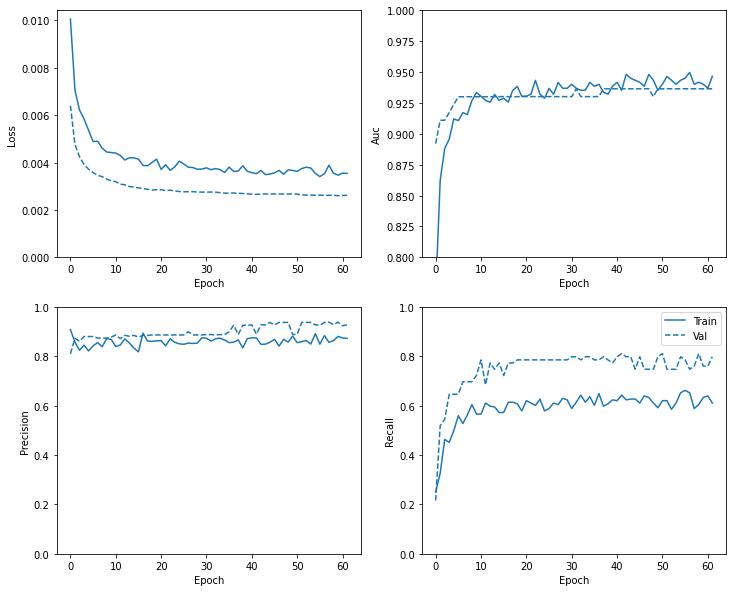

In [27]:
plot_metrics(baseline_history)

참고:  
검증 곡선은 일반적으로 훈련 곡선보다 성능이 좋습니다. 이는 주로 모델을 평가할 때 drop out 레이어가 활성화 되지 않았기 때문에 발생합니다.

### 메트릭 평가

혼동 행렬 을 사용하여 X축이 예측 레이블이고 Y축이 실제 레이블인 실제 레이블과 예측 레이블을 요약할 수 있습니다.

In [28]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [29]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

테스트 데이터 세트에서 모델을 평가하고 위에서 만든 측정 항목의 결과를 표시합니다.

loss :  0.002540057757869363
tp :  80.0
fp :  9.0
tn :  56853.0
fn :  20.0
accuracy :  0.9994909167289734
precision :  0.898876428604126
recall :  0.800000011920929
auc :  0.9397037029266357

Legitimate Transactions Detected (True Negatives):  56853
Legitimate Transactions Incorrectly Detected (False Positives):  9
Fraudulent Transactions Missed (False Negatives):  20
Fraudulent Transactions Detected (True Positives):  80
Total Fraudulent Transactions:  100


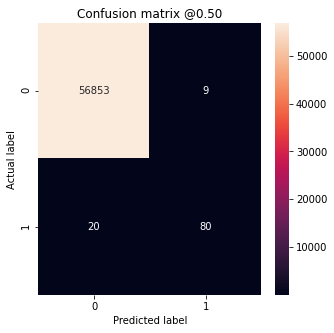

In [30]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
      print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

카드 부정거래의 경우,  
부정거래인데 잘못판단하는것(false negative)이 정당 거래인데 잘못 판단하는 것(false negative) 보다 훨씬 위험하다.  
후자의 경우 고객에게 이메일을 보내 확인해보도록 이메일을 보낼 수 있지만 실제 부정거래인데 감지를 못하는 것은 큰 위험을 무방비로 놔두는것이다.  
따라서 false positive의 수를 늘리더라도 false negative의 수를 줄이는 것이 바람직하다.

---
### ROC plotting

 이 그래프는 출력 임계값을 조정하기만 해도 모델이 도달할 수 있는 성능 범위를 한눈에 보여주기 때문에 유용합니다.

In [31]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

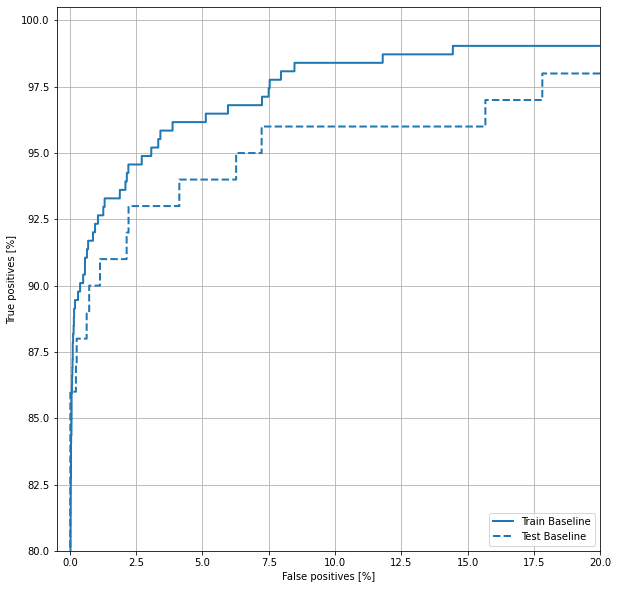

In [32]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

분류자는 정밀도와 리콜을 모두 최대화 하려고 할 때 종종 도전해야 할 문제에 직면하는데, 이는 불균형 데이터세트로 작업할 때 특히 그러합니다.

이 예시에서 거짓음성(부정 거래를 놓친 경우)은 금전적인 비용을 초래하지만 , 거짓 양성(거래가 사기 행위로 잘못 표시됨)은 사용자들의 만족도를 감소시킬 수 있습니다.

---
## 클래스 가중치
### 클래스 가중치 계산
목표는 부정 거래를 식별하는 것이지만, 여러분은 작업할 수 있는 긍정적인 샘플이 많지 않기 깨문에 분류자가 이용할 수 있는 몇 가지 예에 가중치를 두고자 할 것입니다. 매개 변수를 통해 각 클래스에 대한 Keras 가중치를 전달한다면 이 과정을 할 수 있습니다. 이로 인해 모델이 덜 표현된 클래스의 예에 "더 많은 주의를 기울이십시오"라고 할 수도 있습니다.

In [33]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### 클래스 가중치로 모델 교육

이제 해당 모델이 예측에 어떤 영향을 미치는지 확인하기 위하여 클래스 가중치로 모델을 재 교육하고 평가해 보십시오.

참고:  
class_weights 를 사용하면 손실 범위가 바뀝니다. 이는 최적기에 따라 학습의 안정성에 영향을 미칠 수 있습니다. **단계 크기가 그라데이션의 크기에 따라 달라지는 optimizers.SGD 와 같은 최적화 도구는 실패할 수 있습니다.** 여기서 사용되는 최적화기인 **optimizers.Adam 은 스케일링 변화에 영향을 받지 않습니다.** 또한 가중치 때문에 전체 손실은 두 모델 간에 비교할 수 없습니다.

In [34]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
90/90 [==============================] - 1s 9ms/step - loss: 2.2745 - tp: 119.0000 - fp: 19.0000 - tn: 238806.0000 - fn: 294.0000 - accuracy: 0.9987 - precision: 0.8623 - recall: 0.2881 - auc: 0.7939 - val_loss: 0.0064 - val_tp: 21.0000 - val_fp: 6.0000 - val_tn: 45484.0000 - val_fn: 58.0000 - val_accuracy: 0.9986 - val_precision: 0.7778 - val_recall: 0.2658 - val_auc: 0.8892
Epoch 2/100
90/90 [==============================] - 0s 3ms/step - loss: 1.2526 - tp: 127.0000 - fp: 117.0000 - tn: 181846.0000 - fn: 186.0000 - accuracy: 0.9983 - precision: 0.5205 - recall: 0.4058 - auc: 0.8823 - val_loss: 0.0065 - val_tp: 58.0000 - val_fp: 8.0000 - val_tn: 45482.0000 - val_fn: 21.0000 - val_accuracy: 0.9994 - val_precision: 0.8788 - val_recall: 0.7342 - val_auc: 0.9322
Epoch 3/100
90/90 [==============================] - 0s 3ms/step - loss: 0.7347 - tp: 199.0000 - fp: 400.0000 - tn: 181563.0000 - fn: 114.0000 - accuracy: 0.9972 - precision: 0.3322 - recall: 0.6358 - auc: 0.9218 - va

Epoch 22/100
90/90 [==============================] - 0s 3ms/step - loss: 0.2142 - tp: 278.0000 - fp: 5953.0000 - tn: 176010.0000 - fn: 35.0000 - accuracy: 0.9671 - precision: 0.0446 - recall: 0.8882 - auc: 0.9725 - val_loss: 0.0893 - val_tp: 70.0000 - val_fp: 965.0000 - val_tn: 44525.0000 - val_fn: 9.0000 - val_accuracy: 0.9786 - val_precision: 0.0676 - val_recall: 0.8861 - val_auc: 0.9847
Epoch 23/100
90/90 [==============================] - 0s 3ms/step - loss: 0.2317 - tp: 280.0000 - fp: 6376.0000 - tn: 175587.0000 - fn: 33.0000 - accuracy: 0.9648 - precision: 0.0421 - recall: 0.8946 - auc: 0.9676 - val_loss: 0.0892 - val_tp: 70.0000 - val_fp: 963.0000 - val_tn: 44527.0000 - val_fn: 9.0000 - val_accuracy: 0.9787 - val_precision: 0.0678 - val_recall: 0.8861 - val_auc: 0.9853
Epoch 24/100
90/90 [==============================] - 0s 3ms/step - loss: 0.2083 - tp: 284.0000 - fp: 6189.0000 - tn: 175774.0000 - fn: 29.0000 - accuracy: 0.9659 - precision: 0.0439 - recall: 0.9073 - auc: 0.974

Epoch 43/100
90/90 [==============================] - 0s 3ms/step - loss: 0.1978 - tp: 282.0000 - fp: 5940.0000 - tn: 176023.0000 - fn: 31.0000 - accuracy: 0.9672 - precision: 0.0453 - recall: 0.9010 - auc: 0.9730 - val_loss: 0.0815 - val_tp: 70.0000 - val_fp: 844.0000 - val_tn: 44646.0000 - val_fn: 9.0000 - val_accuracy: 0.9813 - val_precision: 0.0766 - val_recall: 0.8861 - val_auc: 0.9864
Epoch 44/100
90/90 [==============================] - 0s 3ms/step - loss: 0.1643 - tp: 291.0000 - fp: 5335.0000 - tn: 176628.0000 - fn: 22.0000 - accuracy: 0.9706 - precision: 0.0517 - recall: 0.9297 - auc: 0.9799 - val_loss: 0.0756 - val_tp: 70.0000 - val_fp: 779.0000 - val_tn: 44711.0000 - val_fn: 9.0000 - val_accuracy: 0.9827 - val_precision: 0.0824 - val_recall: 0.8861 - val_auc: 0.9869
Epoch 45/100
90/90 [==============================] - 0s 3ms/step - loss: 0.1749 - tp: 283.0000 - fp: 5348.0000 - tn: 176615.0000 - fn: 30.0000 - accuracy: 0.9705 - precision: 0.0503 - recall: 0.9042 - auc: 0.979

### 학습 이력 조회

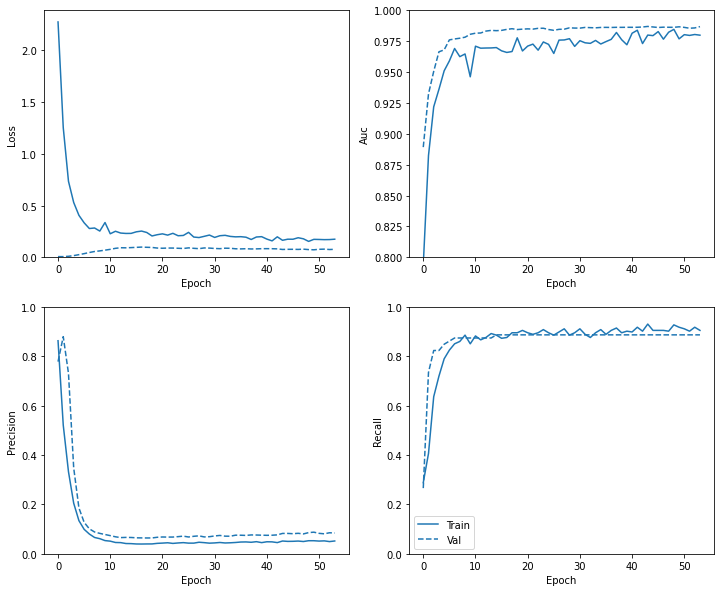

In [35]:
plot_metrics(weighted_history)

### 지표평가

In [36]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.07673771679401398
tp :  90.0
fp :  987.0
tn :  55875.0
fn :  10.0
accuracy :  0.9824970960617065
precision :  0.08356545865535736
recall :  0.8999999761581421
auc :  0.9875192642211914

Legitimate Transactions Detected (True Negatives):  55875
Legitimate Transactions Incorrectly Detected (False Positives):  987
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  90
Total Fraudulent Transactions:  100


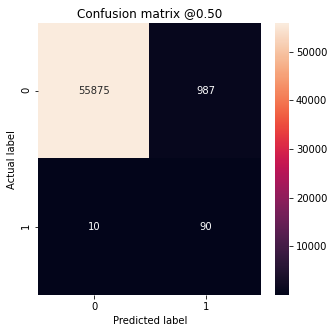

In [37]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

여기서 클래스 가중치를 사용하면 거짓 긍정이 더 많기 때문에 정확도와 정밀도가 낮다는 것을 알 수 있지만, 반대로 리콜과 AUC는 참 긍정이 더 많은 모델입니다. 정확도가 낮음에도 불구하고 이 모델은 리콜이 더 높습니다.(그리고 더 많은 부정 거래를 식별한다.) 물론 두 가지 유형의 오류에는 모두 비용이 발생합니다.(너무 많은 합법적인 거래를 사기로 표시하여 사용자를 괴롭히는 것을 원하지 않을 것입니다.) 응용 프로그램에 대하여 이러한 다양한 유형의 오류 간의 절충을 신중하게 고려하십시오.

---
### ROC plotting

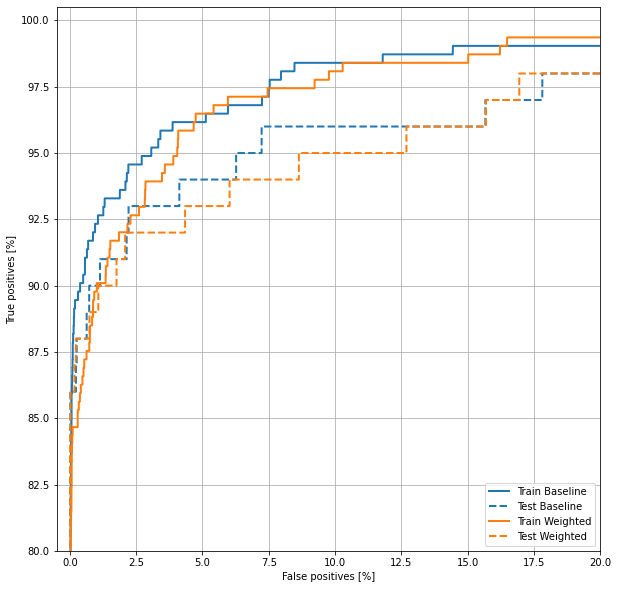

In [38]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

## 오버샘플링
### 소수계급 오버샘플링


In [39]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [40]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181963, 29)

In [42]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363926, 29)

tf.data 사용

[tf.data](https://www.tensorflow.org/api_docs/python/tf/data) 사용하는 경우 균형 잡힌 예제를 생성하는 가장 쉬운 방법은 positive 그리고 negative 데이터 세트로 시작하여 병합하는 것입니다. 더 많은 예는 [tf.data guide](https://www.tensorflow.org/guide/data) 를 참조하세요.

In [43]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [44]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [ 0.60121795  0.33808574 -0.32354374  0.53699631  0.17807292 -0.58560746
  0.1862297  -0.03395355 -0.39373057 -0.53669544  2.23626615  0.6555942
 -0.31178818 -1.08889527  0.56231079  0.45573723  1.34170253  0.30622988
 -0.62752971 -0.1346538  -0.08364384 -0.17668356 -0.06145978  0.17968507
  0.83782239  0.76369593 -0.0447022   0.09753881 -1.58755626]

Label:  1


[experimental.sample_from_datasets](https://www.tensorflow.org/api_docs/python/tf/data/experimental/sample_from_datasets) 를 사용하여 두 가지를 병합합니다

In [45]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [46]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.4970703125


이 데이터 세트를 사용하려면 epoch 당 단계 수가 필요합니다.

이 경우 "epoch" 의 정의는 명확하지 않습니다. 각 부정적인 예를 한번 볼 때 필요한 배치 수라고 가정합니다

In [47]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### 오버 샘플링 된 데이터에 대한 학습

이제 클래스 가중치를 사용하는 대신 리 샘플링 된 데이터 세트로 모델을 학습하여 이러한 방법이 어떻게 비교되는지 확인하십시오.

참고: 긍정적인 예를 복제하여 데이터가 균형을 이루었기 때문에 총 데이터 세트 크기가 더 크고 각 세대가 더 많은 학습 단계를 위해 실행됩니다.

In [48]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 6s 22ms/step - loss: 0.3422 - tp: 242970.0000 - fp: 44816.0000 - tn: 296504.0000 - fn: 42016.0000 - accuracy: 0.8614 - precision: 0.8443 - recall: 0.8526 - auc: 0.9343 - val_loss: 0.1565 - val_tp: 71.0000 - val_fp: 1099.0000 - val_tn: 44391.0000 - val_fn: 8.0000 - val_accuracy: 0.9757 - val_precision: 0.0607 - val_recall: 0.8987 - val_auc: 0.9883
Epoch 2/100
278/278 [==============================] - 6s 20ms/step - loss: 0.1732 - tp: 259703.0000 - fp: 12400.0000 - tn: 272340.0000 - fn: 24901.0000 - accuracy: 0.9345 - precision: 0.9544 - recall: 0.9125 - auc: 0.9802 - val_loss: 0.0895 - val_tp: 71.0000 - val_fp: 819.0000 - val_tn: 44671.0000 - val_fn: 8.0000 - val_accuracy: 0.9819 - val_precision: 0.0798 - val_recall: 0.8987 - val_auc: 0.9909
Epoch 3/100
278/278 [==============================] - 5s 20ms/step - loss: 0.1407 - tp: 263822.0000 - fp: 9688.0000 - tn: 275057.0000 - fn: 20777.0000 - accuracy: 0.9465 - precision: 0.9646 - 

### 훈련 이력 재확인

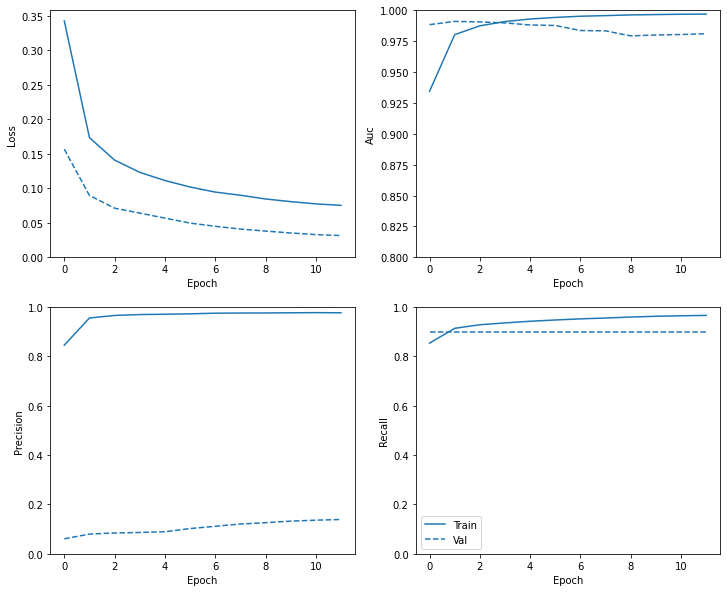

In [49]:
plot_metrics(resampled_history)

### 지표 평가

In [50]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.08971584588289261
tp :  89.0
fp :  1030.0
tn :  55832.0
fn :  11.0
accuracy :  0.9817246794700623
precision :  0.07953529804944992
recall :  0.8899999856948853
auc :  0.9887917637825012

Legitimate Transactions Detected (True Negatives):  55832
Legitimate Transactions Incorrectly Detected (False Positives):  1030
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  89
Total Fraudulent Transactions:  100


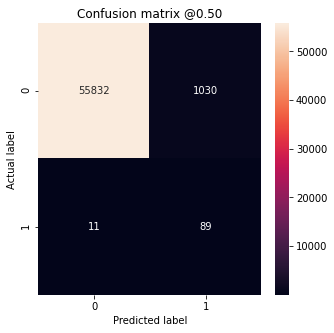

In [52]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### ROC plotting

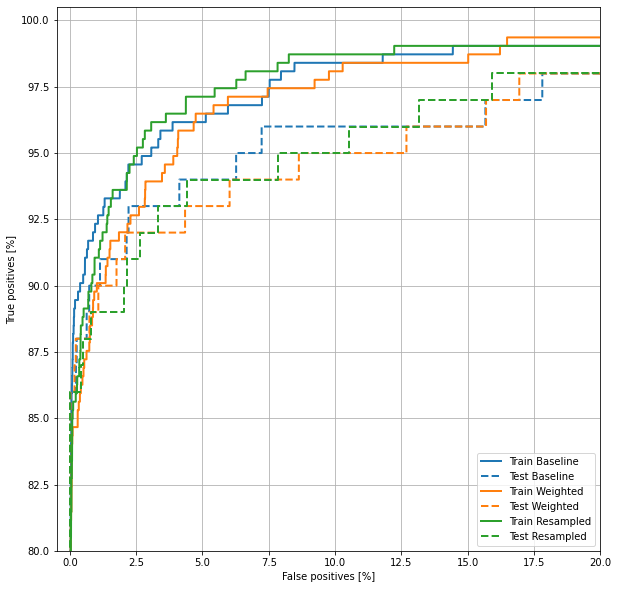

In [53]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')